In [1]:
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
# sns.set_style({'font.sans-serif':['SimHei','Arial']})
# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

In [3]:
# 数据加载
baseA_predict = pd.read_excel('附件1 监测点A空气质量预报基础数据.xlsx', sheet_name='监测点A逐小时污染物浓度与气象一次预报数据')
baseA_real_hour = pd.read_excel('附件1 监测点A空气质量预报基础数据.xlsx', sheet_name='监测点A逐小时污染物浓度与气象实测数据')
baseA_real_day = pd.read_excel('附件1 监测点A空气质量预报基础数据.xlsx', sheet_name='监测点A逐日污染物浓度实测数据')

baseB_predict = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点B逐小时污染物浓度与气象一次预报数据')
baseB_real_hour = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点B逐小时污染物浓度与气象实测数据')
baseB_real_day = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点B逐日污染物浓度实测数据')

baseC_predict = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点C逐小时污染物浓度与气象一次预报数据')
baseC_real_hour = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点C逐小时污染物浓度与气象实测数据')
baseC_real_day = pd.read_excel('附件2 监测点B、C空气质量预报基础数据.xlsx', sheet_name='监测点C逐日污染物浓度实测数据')

In [4]:
baseA_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25416 entries, 0 to 25415
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   模型运行日期              25416 non-null  datetime64[ns]
 1   预测时间                25416 non-null  datetime64[ns]
 2   地点                  25416 non-null  object        
 3   近地2米温度（℃）           25416 non-null  float64       
 4   地表温度（K）             25416 non-null  float64       
 5   比湿（kg/kg）           25416 non-null  float64       
 6   湿度（%）               25416 non-null  float64       
 7   近地10米风速（m/s）        25416 non-null  float64       
 8   近地10米风向（°）          25416 non-null  float64       
 9   雨量（mm）              25416 non-null  float64       
 10  云量                  25416 non-null  float64       
 11  边界层高度（m）            25416 non-null  float64       
 12  大气压（Kpa）            25416 non-null  float64       
 13  感热通量（W/m²）          25416 non-null  float64   

In [5]:
# 转换数据格式并进行数据清洗
def change_type(dfs, df_name):
    res = []
    if df_name == 'predict':
        # 处理逐小时污染物浓度与气象一次预报数据
        for df in dfs:
            df.columns = ['模型运行日期', '预测时间', '地点', '近地2米温度（℃）', '地表温度（K）', '比湿（kg/kg）', '湿度（%）',
               '近地10米风速（m/s）', '近地10米风向（°）', '雨量（mm）', '云量', '边界层高度（m）', '大气压（Kpa）',
               '感热通量（W/m²）', '潜热通量（W/m²）', '长波辐射（W/m²）', '短波辐射（W/m²）', '地面太阳能辐射（W/m²）',
               'SO2小时平均浓度(μg/m³)', 'NO2小时平均浓度(μg/m³)', 'PM10小时平均浓度(μg/m³)',
               'PM2.5小时平均浓度(μg/m³)', 'O3小时平均浓度(μg/m³)', 'CO小时平均浓度(mg/m³)']

            for column_numeric in ['近地2米温度（℃）', '地表温度（K）', '比湿（kg/kg）', '湿度（%）',
               '近地10米风速（m/s）', '近地10米风向（°）', '雨量（mm）', '云量', '边界层高度（m）', '大气压（Kpa）',
               '感热通量（W/m²）', '潜热通量（W/m²）', '长波辐射（W/m²）', '短波辐射（W/m²）', '地面太阳能辐射（W/m²）',
               'SO2小时平均浓度(μg/m³)', 'NO2小时平均浓度(μg/m³)', 'PM10小时平均浓度(μg/m³)',
               'PM2.5小时平均浓度(μg/m³)', 'O3小时平均浓度(μg/m³)', 'CO小时平均浓度(mg/m³)']:
                df[column_numeric] = pd.to_numeric(df[column_numeric], errors='coerce')
                # 将负数置为0
                df[column_numeric][ df[column_numeric] < 0] = 0
            df['模型运行日期'] =  pd.to_datetime(df['模型运行日期'])
            df['预测时间'] =  pd.to_datetime(df['预测时间'])
            # 临近值填充
            df = df.fillna(method='pad')
            res.append(df)
    if df_name == 'real_hour':
        # 处理逐小时污染物浓度与气象实测数据
        for df in dfs:
            df.columns = ['监测时间', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
               'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)', '温度(℃)', '湿度(%)',
               '气压(MBar)', '风速(m/s)', '风向(°)']

            for column_numeric in ['SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
               'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)', '温度(℃)', '湿度(%)',
               '气压(MBar)', '风速(m/s)', '风向(°)']:
                df[column_numeric] = pd.to_numeric(df[column_numeric], errors='coerce')
                # 将负数置为0
                df[column_numeric][ df[column_numeric] < 0] = 0
            df['监测时间'] =  pd.to_datetime(df['监测时间'])
            # 临近值填充
            df = df.fillna(method='pad')
            res.append(df)
    if df_name == 'real_day':
        # 处理逐日污染物浓度实测数据
        for df in dfs:
            df.columns = ['监测日期', '地点', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
               'PM2.5监测浓度(μg/m³)', 'O3最大八小时滑动平均监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']
            for column_numeric in ['SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
               'PM2.5监测浓度(μg/m³)', 'O3最大八小时滑动平均监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']:
                df[column_numeric] = pd.to_numeric(df[column_numeric], errors='coerce')
                # 将负数置为0
                df[column_numeric][ df[column_numeric] < 0] = 0
            df['监测日期'] =  pd.to_datetime(df['监测日期'])
            # 临近值填充
            df = df.fillna(method='pad')
            res.append(df)
    return res
baseA_predict, baseB_predict, baseC_predict = change_type((baseA_predict, baseB_predict, baseC_predict), 'predict')
baseA_real_hour, baseB_real_hour, baseC_real_hour = change_type((baseA_real_hour, baseB_real_hour, baseC_real_hour), 'real_hour')
baseA_real_day, baseB_real_day, baseC_real_day = change_type((baseA_real_day, baseB_real_day, baseC_real_day), 'real_day')


In [6]:
# 保存初步数据清理数据
# baseA_predict.to_excel("Q3/baseA_predict.xlsx",encoding='gbk')
# baseB_predict.to_excel("Q3/baseB_predict.xlsx",encoding='gbk')
# baseC_predict.to_excel("Q3/baseC_predict.xlsx",encoding='gbk')

# baseA_real_hour.to_excel("Q3/baseA_real_hour.xlsx",encoding='gbk')
# baseB_real_hour.to_excel("Q3/baseB_real_hour.xlsx",encoding='gbk')
# baseC_real_hour.to_excel("Q3/baseC_real_hour.xlsx",encoding='gbk')

# baseA_real_day.to_excel("Q3/baseA_real_day.xlsx",encoding='gbk')
# baseB_real_day.to_excel("Q3/baseB_real_day.xlsx",encoding='gbk')
# baseC_real_day.to_excel("Q3/baseC_real_day.xlsx",encoding='gbk')

In [7]:
# 探索性数据分析
# 单特征展示Have a glance at data
import math
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)

    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        #ax.set_title(column)
        plt.xlabel(column, fontsize=20)
        plt.ylabel('',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset,palette='plasma')
            plt.xticks(rotation=25)
        else:
            #直方图，频数
            
            g = sns.distplot(dataset[column],kde_kws={'bw': 0.1})
            plt.ylabel(ylabel='Density',fontsize=20)
            plt.xticks(rotation=25)
            
    


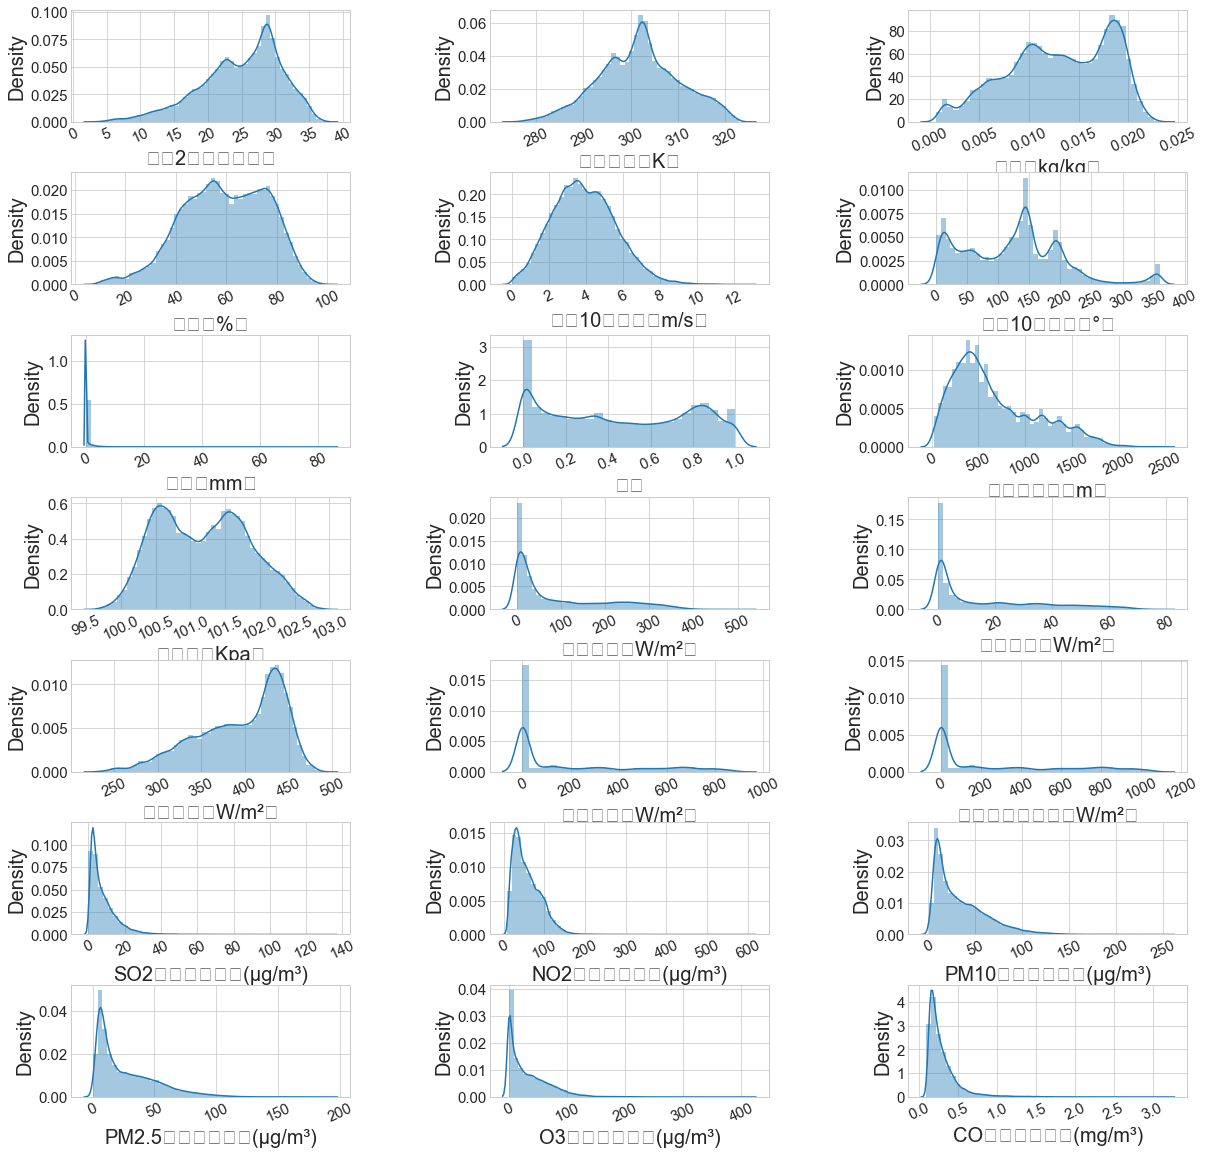

In [8]:
plot_distribution(baseA_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

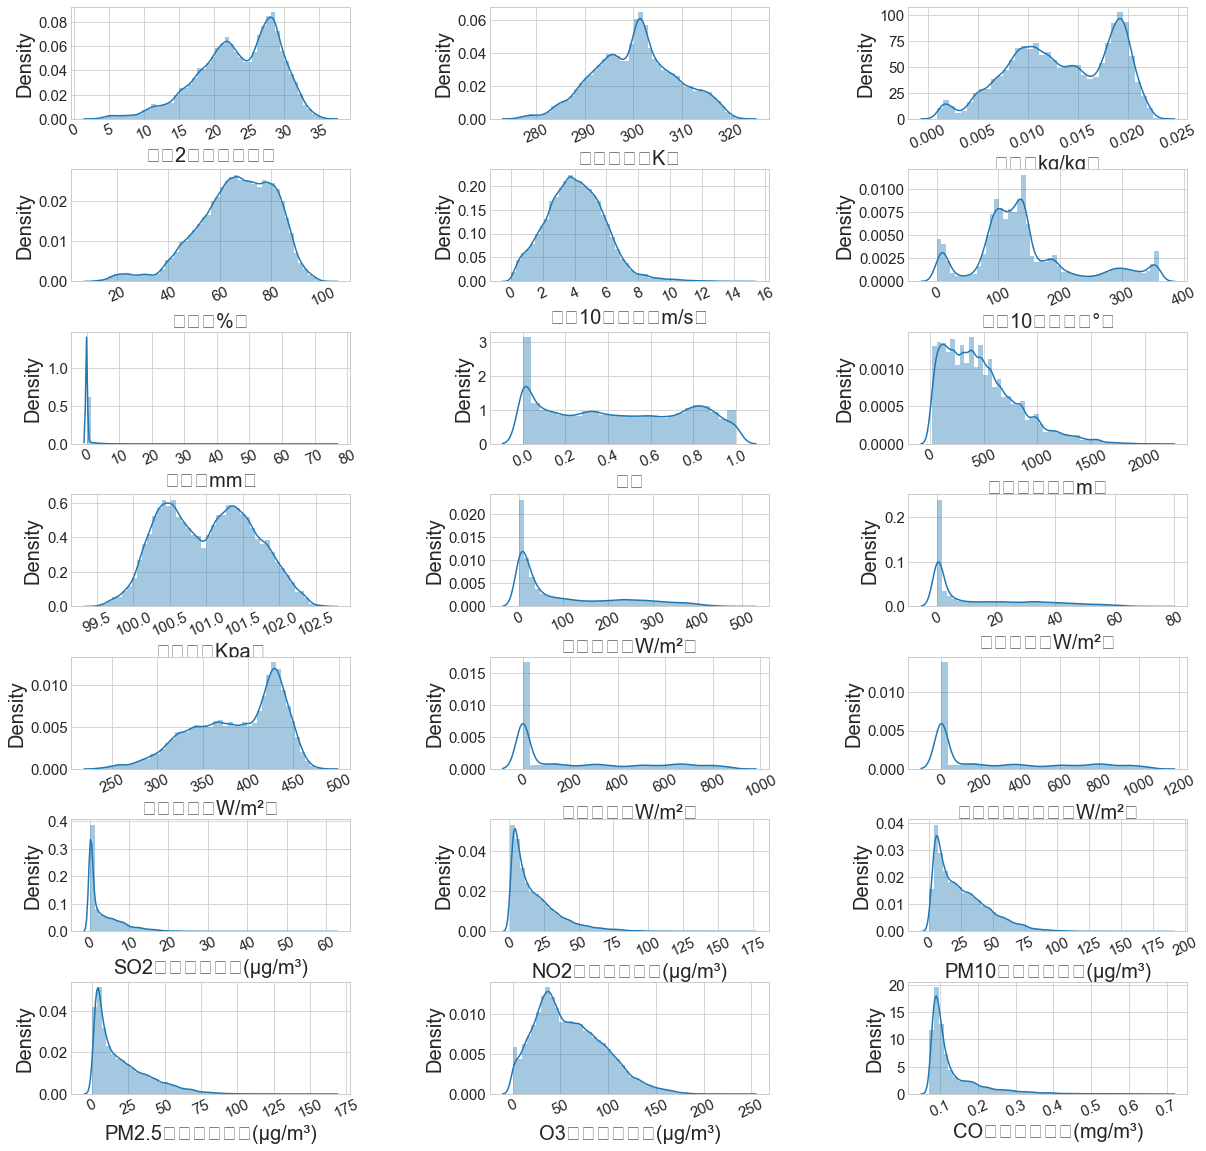

In [9]:
plot_distribution(baseB_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

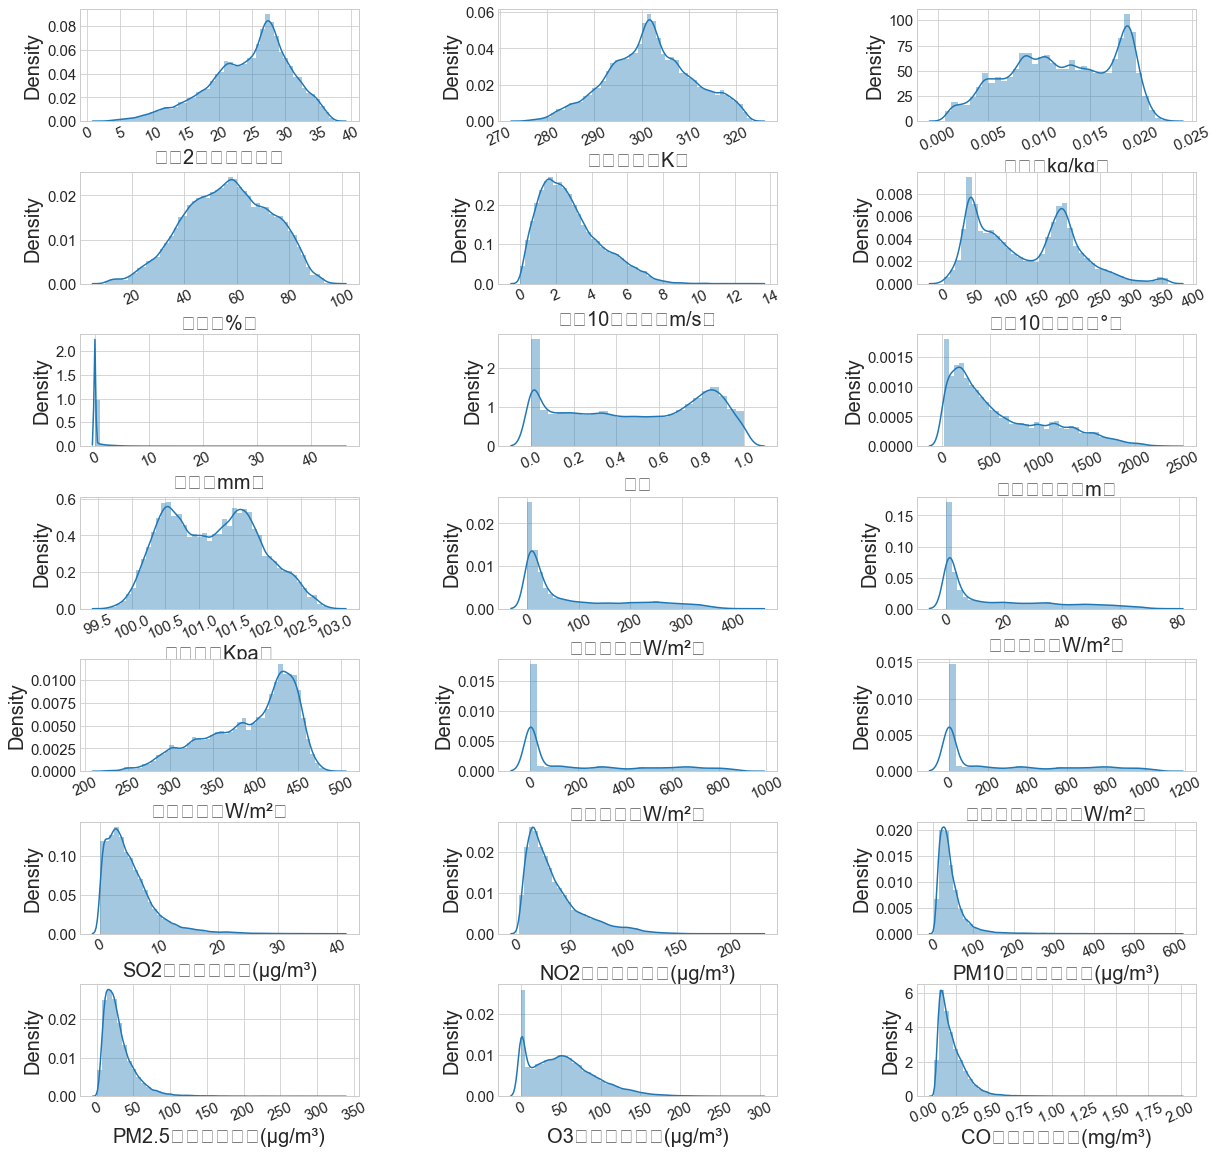

In [10]:
plot_distribution(baseC_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

In [11]:
# 箱型图
# 单变量箱型图
def plot_box(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)

    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        #ax.set_title(column)
        plt.xlabel(column, fontsize=20)
        plt.ylabel('',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

        #箱型图
        g = sns.boxplot(dataset[column])
        plt.ylabel(ylabel='Density',fontsize=20)
        plt.xticks(rotation=25)

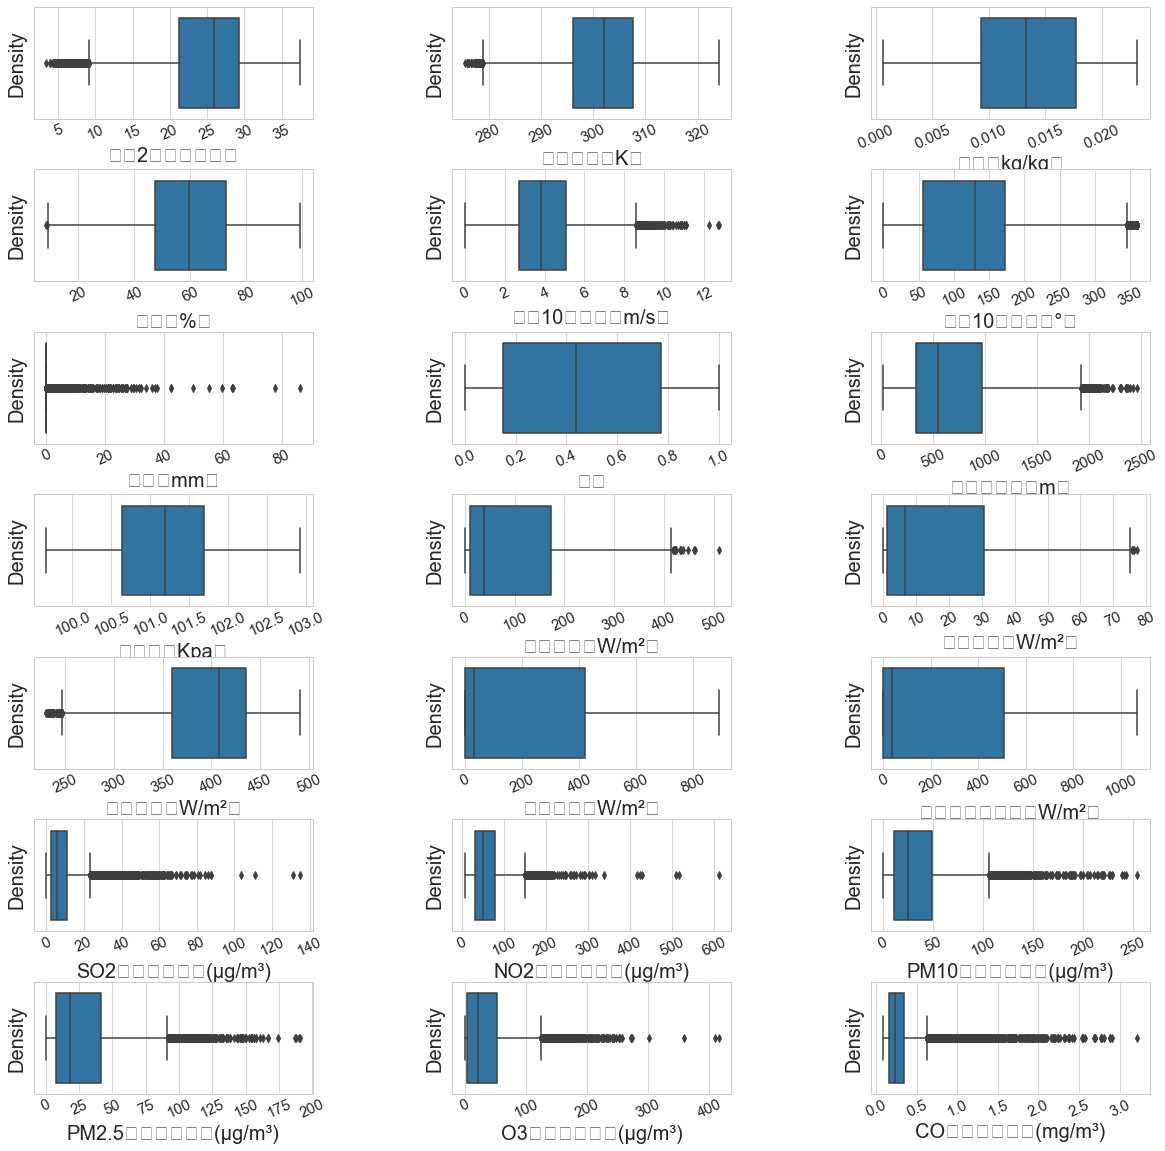

In [12]:
plot_box(baseA_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

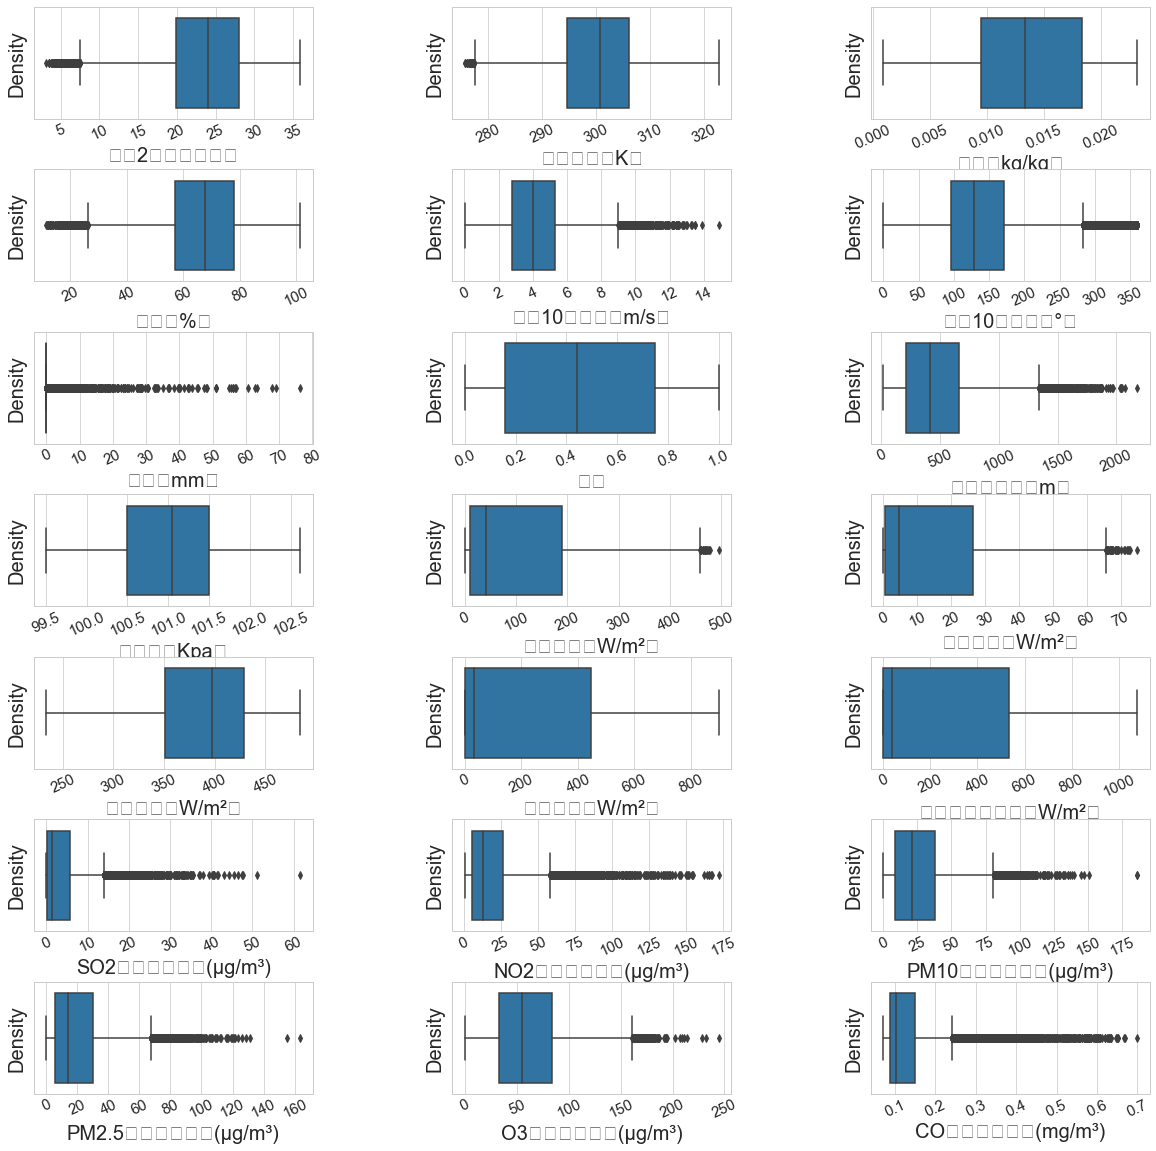

In [13]:
plot_box(baseB_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

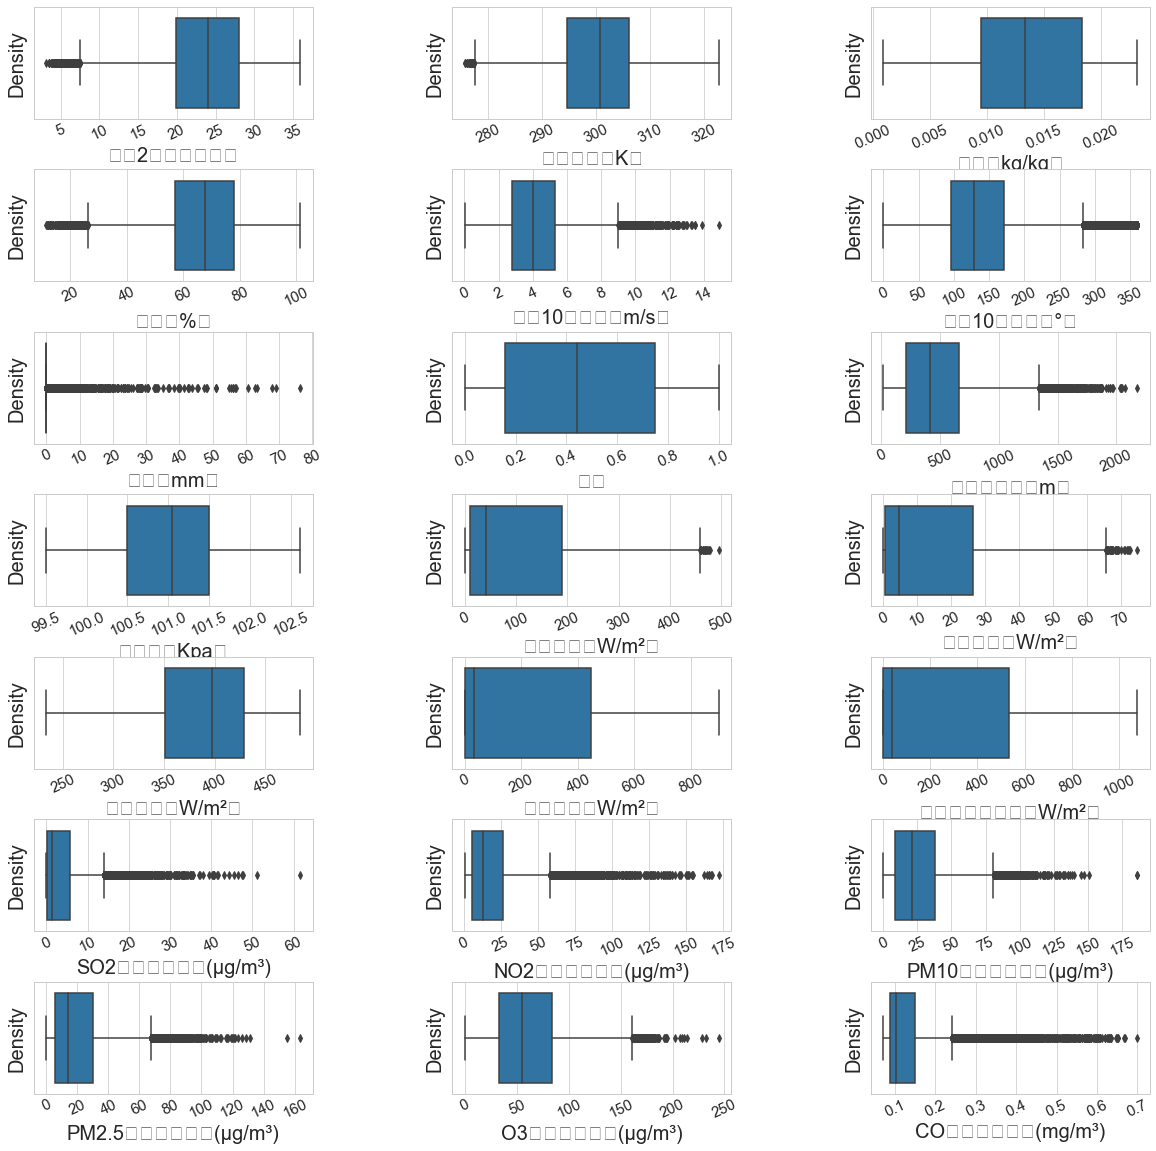

In [14]:
plot_box(baseB_predict[
    ['近地2米温度（℃）','地表温度（K）','比湿（kg/kg）', '湿度（%）','近地10米风速（m/s）',
     '近地10米风向（°）','雨量（mm）','云量','边界层高度（m）','大气压（Kpa）','感热通量（W/m²）',
    '潜热通量（W/m²）','长波辐射（W/m²）','短波辐射（W/m²）', '地面太阳能辐射（W/m²）','SO2小时平均浓度(μg/m³)',
    'NO2小时平均浓度(μg/m³)','PM10小时平均浓度(μg/m³)','PM2.5小时平均浓度(μg/m³)','O3小时平均浓度(μg/m³)',
    'CO小时平均浓度(mg/m³)']], cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

In [14]:
# 去除无用数据（仅选择2020-7-20日之后的实测数据和2021-07-13 07:00:00之前的预测数据）
def extract_data(dfs, df_name):
    res = []
    if df_name == 'predict':
        for df in dfs:
            res.append(df)
    if df_name == 'real_hour':
        for df in dfs:
            df = df.set_index(['监测时间'], drop=False)
            df = df.loc['2020-07-20 00:00:00':'2021-07-12 23:00:00']
            res.append(df)
    if df_name == 'real_day':
        for df in dfs:
            df = df.set_index(['监测日期'], drop=False)
            df = df.loc['2020-07-20':'2021-07-12']
            res.append(df)
    return res
baseA_predict, baseB_predict, baseC_predict = extract_data((baseA_predict, baseB_predict, baseC_predict),df_name= 'predict')
baseA_real_hour, baseB_real_hour, baseC_real_hour = extract_data((baseA_real_hour, baseB_real_hour, baseC_real_hour), df_name='real_hour')
baseA_real_day, baseB_real_day, baseC_real_day = extract_data((baseA_real_day, baseB_real_day, baseC_real_day), df_name='real_day')

In [10]:
# 为一次预报数据增加关联索引
from pandas.tseries.offsets import *
def time_index(dfs):
    res = []
    for df in dfs:
        df['实测时间'] = df['预测时间']
        df['实测时间'] = df['实测时间'] - DateOffset(days=3)
        new_columns = ['模型运行日期', '预测时间', '实测时间', '地点', '近地2米温度（℃）', '地表温度（K）', '比湿（kg/kg）', '湿度（%）',
                       '近地10米风速（m/s）', '近地10米风向（°）', '雨量（mm）', '云量', '边界层高度（m）', '大气压（Kpa）',
                       '感热通量（W/m²）', '潜热通量（W/m²）', '长波辐射（W/m²）', '短波辐射（W/m²）', '地面太阳能辐射（W/m²）',
                       'SO2小时平均浓度(μg/m³)', 'NO2小时平均浓度(μg/m³)', 'PM10小时平均浓度(μg/m³)',
                       'PM2.5小时平均浓度(μg/m³)', 'O3小时平均浓度(μg/m³)', 'CO小时平均浓度(mg/m³)']
        df = df.reindex(columns=new_columns)
        res.append(df)
    return res
baseA_predict, baseB_predict, baseC_predict = time_index((baseA_predict, baseB_predict, baseC_predict))

In [11]:
baseA_predict

,模型运行日期,预测时间,实测时间,地点,近地2米温度（℃）,地表温度（K）,比湿（kg/kg）,湿度（%）,近地10米风速（m/s）,近地10米风向（°）,...,潜热通量（W/m²）,长波辐射（W/m²）,短波辐射（W/m²）,地面太阳能辐射（W/m²）,SO2小时平均浓度(μg/m³),NO2小时平均浓度(μg/m³),PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³)
0,2020-07-23,2020-07-23 00:00:00,2020-07-20 00:00:00,监测点A,29.8890,304.016,0.018870,66.7409,4.16382,162.577,...,0.94818,428.278,0.0000,0.0000,2.401510,20.9208,8.17336,5.27729,8.787230,0.124491
1,2020-07-23,2020-07-23 01:00:00,2020-07-20 01:00:00,监测点A,29.8736,303.739,0.017556,62.1551,4.65267,171.978,...,1.14987,427.531,0.0000,0.0000,1.448340,14.8144,6.49054,4.33106,12.745300,0.109056
2,2020-07-23,2020-07-23 02:00:00,2020-07-20 02:00:00,监测点A,29.6471,303.419,0.017874,64.1760,4.10031,172.013,...,1.01616,427.428,0.0000,0.0000,1.271610,13.9154,6.86679,4.40045,12.229600,0.105957
3,2020-07-23,2020-07-23 03:00:00,2020-07-20 03:00:00,监测点A,29.4555,303.419,0.018935,68.7958,2.44317,168.135,...,1.89003,442.472,0.0000,0.0000,0.467429,11.1535,5.25900,3.35261,13.780000,0.101764
4,2020-07-23,2020-07-23 04:00:00,2020-07-20 04:00:00,监测点A,28.5189,302.987,0.019881,76.5791,2.57759,207.884,...,6.53753,458.394,0.0000,0.0000,0.574856,13.9989,6.05979,3.59303,9.963330,0.104536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25411,2021-07-13,2021-07-15 19:00:00,2021-07-12 19:00:00,监测点A,34.3963,319.300,0.017129,45.9006,3.08236,157.020,...,49.94120,451.479,567.4070,681.8110,2.679800,44.8120,8.92721,5.66833,0.333226,0.224216
25412,2021-07-13,2021-07-15 20:00:00,2021-07-12 20:00:00,监测点A,34.3593,315.920,0.017551,47.1484,4.45631,164.549,...,41.65230,452.011,377.4950,453.6080,2.937120,41.3621,9.00740,5.67797,0.007336,0.233528
25413,2021-07-13,2021-07-15 21:00:00,2021-07-12 21:00:00,监测点A,33.8754,312.489,0.016992,47.0484,4.99797,152.778,...,27.88200,449.925,178.6100,214.6230,3.084680,41.5508,9.13525,5.76356,0.024794,0.237719
25414,2021-07-13,2021-07-15 22:00:00,2021-07-12 22:00:00,监测点A,32.6011,308.693,0.016529,49.4718,6.08861,141.533,...,15.04470,444.482,21.8066,26.2034,4.003400,42.4011,8.24599,5.43220,0.000928,0.260096


In [12]:
# 将实测浓度与预测值进行拼接
def concat_astime(source_dfs, concat_dfs):
    res = []
    for source_df, concat_df in zip(source_dfs, concat_dfs):
        source_df = source_df.set_index('实测时间', drop=False)
        concat_df = concat_df.set_index('监测时间', drop=False)
        source_df[['SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
                   'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)', '温度(℃)', '湿度(%)',
                   '气压(MBar)', '风速(m/s)', '风向(°)']] = np.nan
        for idx, val in concat_df.iterrows():
            for column_name in ['SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
                   'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)', '温度(℃)', '湿度(%)',
                   '气压(MBar)', '风速(m/s)', '风向(°)']:
                source_df.at[idx, column_name] = val[column_name]
        res.append(source_df)
    return res
baseA_predict, baseB_predict, baseC_predict = concat_astime((baseA_predict, baseB_predict, baseC_predict), (baseA_real_hour, baseB_real_hour, baseC_real_hour))

In [13]:
baseA_predict

,模型运行日期,预测时间,实测时间,地点,近地2米温度（℃）,地表温度（K）,比湿（kg/kg）,湿度（%）,近地10米风速（m/s）,近地10米风向（°）,...,NO2监测浓度(μg/m³),PM10监测浓度(μg/m³),PM2.5监测浓度(μg/m³),O3监测浓度(μg/m³),CO监测浓度(mg/m³),温度(℃),湿度(%),气压(MBar),风速(m/s),风向(°)
实测时间,,,,,,,,,,,,,,,,,,,,,
2020-07-20 00:00:00,2020-07-23,2020-07-23 00:00:00,2020-07-20 00:00:00,监测点A,29.8890,304.016,0.018870,66.7409,4.16382,162.577,...,10.0,7.0,1.0,18.0,0.5,29.9,76.0,1006.5,2.3,242.2
2020-07-20 01:00:00,2020-07-23,2020-07-23 01:00:00,2020-07-20 01:00:00,监测点A,29.8736,303.739,0.017556,62.1551,4.65267,171.978,...,9.0,14.0,0.0,20.0,0.5,29.8,76.0,1006.1,1.8,239.0
2020-07-20 02:00:00,2020-07-23,2020-07-23 02:00:00,2020-07-20 02:00:00,监测点A,29.6471,303.419,0.017874,64.1760,4.10031,172.013,...,9.0,11.0,0.0,19.0,0.5,29.6,77.0,1005.9,1.2,345.9
2020-07-20 03:00:00,2020-07-23,2020-07-23 03:00:00,2020-07-20 03:00:00,监测点A,29.4555,303.419,0.018935,68.7958,2.44317,168.135,...,7.0,12.0,0.0,23.0,0.5,29.6,78.0,1005.9,1.4,286.7
2020-07-20 04:00:00,2020-07-23,2020-07-23 04:00:00,2020-07-20 04:00:00,监测点A,28.5189,302.987,0.019881,76.5791,2.57759,207.884,...,8.0,12.0,0.0,21.0,0.5,29.6,76.0,1006.2,1.4,262.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12 19:00:00,2021-07-13,2021-07-15 19:00:00,2021-07-12 19:00:00,监测点A,34.3963,319.300,0.017129,45.9006,3.08236,157.020,...,15.0,23.0,7.0,62.0,0.5,32.1,70.0,1005.8,1.6,105.6
2021-07-12 20:00:00,2021-07-13,2021-07-15 20:00:00,2021-07-12 20:00:00,监测点A,34.3593,315.920,0.017551,47.1484,4.45631,164.549,...,19.0,22.0,9.0,37.0,0.5,31.6,72.0,1006.1,1.5,100.8
2021-07-12 21:00:00,2021-07-13,2021-07-15 21:00:00,2021-07-12 21:00:00,监测点A,33.8754,312.489,0.016992,47.0484,4.99797,152.778,...,15.0,11.0,9.0,34.0,0.4,31.2,68.0,1006.5,1.1,41.9


<AxesSubplot:>

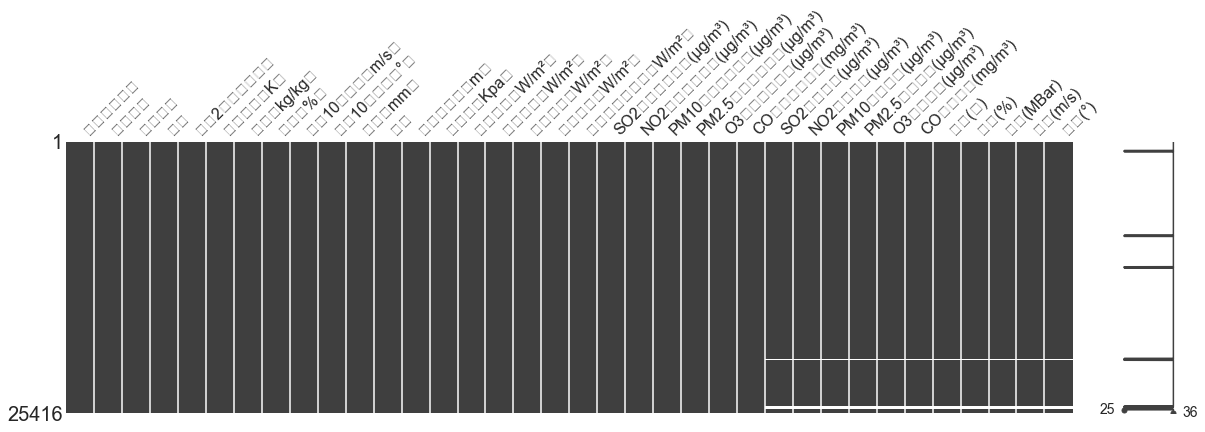

In [15]:
missingno.matrix(baseA_predict, figsize = (20,5))

<AxesSubplot:>

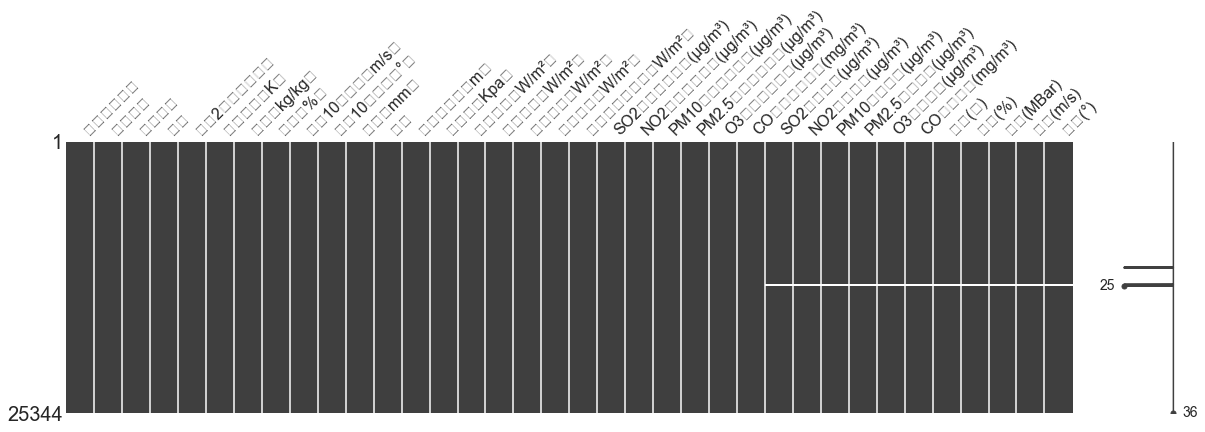

In [16]:
missingno.matrix(baseB_predict, figsize = (20,5))

<AxesSubplot:>

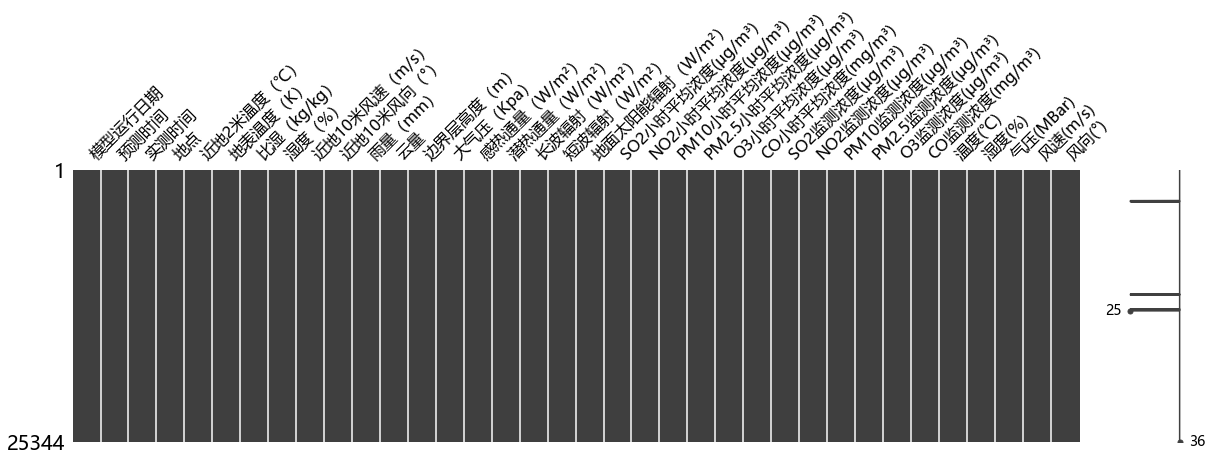

In [9]:
missingno.matrix(baseC_predict, figsize = (20,5))

In [14]:
# baseA_predict.to_excel('baseA_concated.xlsx', encoding='gbk')
# baseB_predict.to_excel('baseB_concated.xlsx', encoding='gbk')
# baseC_predict.to_excel('baseC_concated.xlsx', encoding='gbk')

In [17]:
# 数据预处理,缺失值填充
def dfs_clean(dfs):
    res = []
    for df in dfs:
        df = df.fillna(method='pad')
        res.append(df)
    return res
baseA_predict, baseB_predict, baseC_predict = dfs_clean((baseA_predict, baseB_predict, baseC_predict))


<AxesSubplot:>

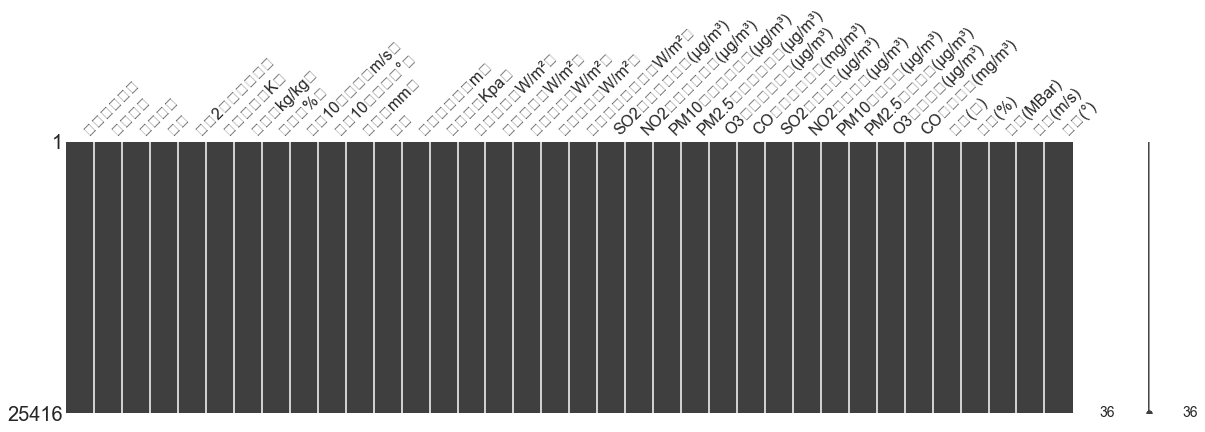

In [18]:
# 填充后
missingno.matrix(baseA_predict, figsize = (20,5))

<AxesSubplot:>

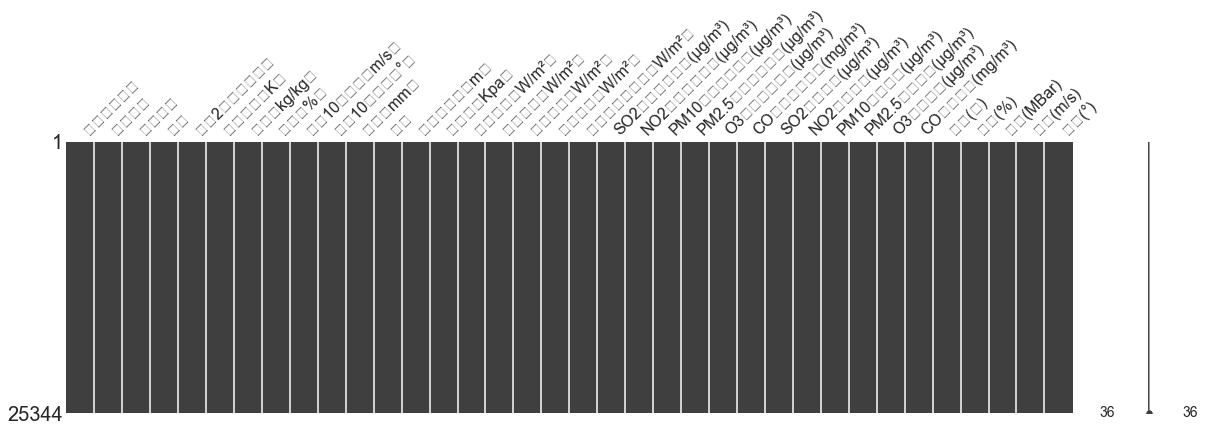

In [19]:
missingno.matrix(baseB_predict, figsize = (20,5))

<AxesSubplot:>

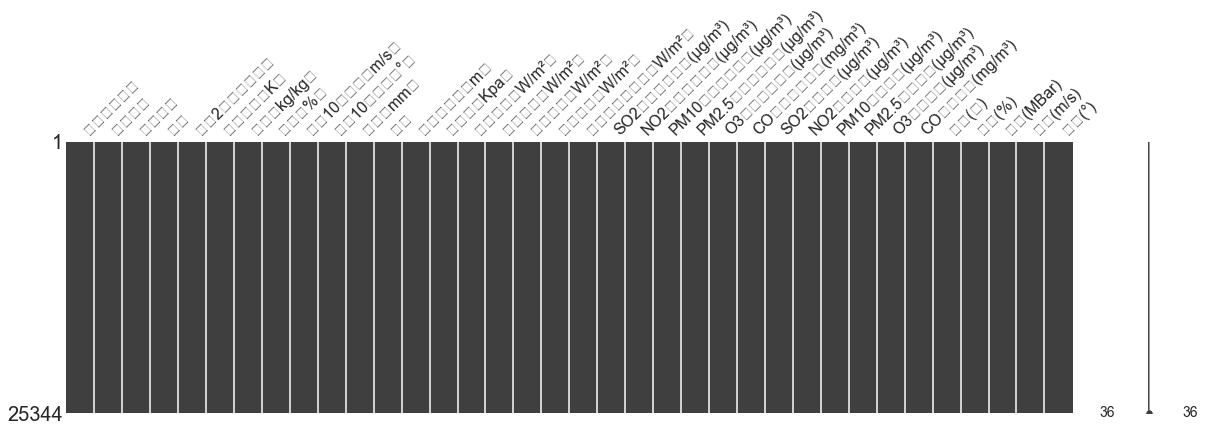

In [20]:
missingno.matrix(baseC_predict, figsize = (20,5))

In [21]:
# 将数据进行融合
base_concated = pd.concat([baseA_predict, baseB_predict, baseC_predict], axis=0)

In [22]:
base_concated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76104 entries, 2020-07-20 00:00:00 to 2021-07-12 23:00:00
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   模型运行日期              76104 non-null  datetime64[ns]
 1   预测时间                76104 non-null  datetime64[ns]
 2   实测时间                76104 non-null  datetime64[ns]
 3   地点                  76104 non-null  object        
 4   近地2米温度（℃）           76104 non-null  float64       
 5   地表温度（K）             76104 non-null  float64       
 6   比湿（kg/kg）           76104 non-null  float64       
 7   湿度（%）               76104 non-null  float64       
 8   近地10米风速（m/s）        76104 non-null  float64       
 9   近地10米风向（°）          76104 non-null  float64       
 10  雨量（mm）              76104 non-null  float64       
 11  云量                  76104 non-null  float64       
 12  边界层高度（m）            76104 non-null  float64       
 13  大气压（Kpa）   

In [23]:
# 特征工程
base_concated_temp = base_concated
# 将地点进行one-hot编码
base_concated_temp = pd.get_dummies(base_concated_temp, columns={'地点'})

In [24]:
# base_concated_temp
# 相关性分析
# 构造相关性矩阵
corr_matrx = base_concated_temp.corr()[['SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)',
                   'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']]

<AxesSubplot:>

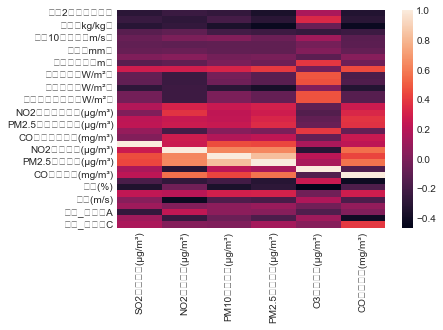

In [25]:
sns.heatmap(corr_matrx)

In [46]:
corr_matrx

,SO2监测浓度(μg/m³),NO2监测浓度(μg/m³),PM10监测浓度(μg/m³),PM2.5监测浓度(μg/m³),O3监测浓度(μg/m³),CO监测浓度(mg/m³)
近地2米温度（℃）,-0.296087,-0.240033,-0.265801,-0.357629,0.150081,-0.329435
地表温度（K）,-0.243817,-0.281784,-0.199081,-0.302816,0.335411,-0.303194
比湿（kg/kg）,-0.308809,-0.265159,-0.360090,-0.428617,-0.071327,-0.419171
湿度（%）,-0.127292,-0.102571,-0.206215,-0.227410,-0.256528,-0.235231
近地10米风速（m/s）,-0.072588,-0.002522,0.021785,-0.059982,0.115404,-0.126400
近地10米风向（°）,-0.092798,-0.104012,-0.100795,-0.098830,-0.026036,-0.116837
雨量（mm）,-0.078030,-0.067870,-0.095137,-0.101501,0.017761,-0.084156
云量,0.007779,0.034872,-0.035083,-0.016490,-0.119194,0.037202
边界层高度（m）,-0.130450,-0.098536,-0.009524,-0.053318,0.383822,-0.050701
大气压（Kpa）,0.281681,0.288811,0.313859,0.396019,-0.035203,0.449642


In [51]:
# 保留相关性强的数据
base_concated.columns
data = base_concated_temp[['近地2米温度（℃）', '地表温度（K）', '比湿（kg/kg）', '湿度（%）', '云量', '边界层高度（m）',
       '大气压（Kpa）', '感热通量（W/m²）', '潜热通量（W/m²）', '长波辐射（W/m²）', '短波辐射（W/m²）', '地面太阳能辐射（W/m²）',
       'SO2小时平均浓度(μg/m³)', 'NO2小时平均浓度(μg/m³)', 'PM10小时平均浓度(μg/m³)', 'PM2.5小时平均浓度(μg/m³)', 
       'O3小时平均浓度(μg/m³)', 'CO小时平均浓度(mg/m³)', 'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)',
       'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)',
       '温度(℃)', '湿度(%)', '气压(MBar)', '风速(m/s)']]
data.index = range(len(data))
new_columns = ['近地2米温度（℃）', '地表温度（K）', '比湿（kg/kg）', '湿度（%）', '云量', '边界层高度（m）',
               '大气压（Kpa）', '感热通量（W/m²）', '潜热通量（W/m²）', '长波辐射（W/m²）', '短波辐射（W/m²）', '地面太阳能辐射（W/m²）',
               'SO2小时平均浓度(μg/m³)', 'NO2小时平均浓度(μg/m³)', 'PM10小时平均浓度(μg/m³)', 'PM2.5小时平均浓度(μg/m³)', 
               'O3小时平均浓度(μg/m³)', 'CO小时平均浓度(mg/m³)', '温度(℃)', '湿度(%)', '气压(MBar)', '风速(m/s)', 
               'SO2监测浓度(μg/m³)', 'NO2监测浓度(μg/m³)', 'PM10监测浓度(μg/m³)', 'PM2.5监测浓度(μg/m³)', 'O3监测浓度(μg/m³)', 'CO监测浓度(mg/m³)']
data = data.reindex(columns=new_columns)

data.to_excel('data.xlsx', encoding='gbk')